In [1]:
import pylangacq as pla
import pandas as pd
import numpy as np
import sys
from collections import Counter
import seaborn as sns


if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Lectura archivos CHAT

#### Se genera un dataframe con las columnas: 'mark_star', 'mark_end', 'transcription', 'sex', 'age' , 'file' , 'WAB_AQ' y 'aphasia_type'

In [ ]:
# Load transcriptions

def read_chat_files(file_directory):
    ds = pla.read_chat(file_directory)
    files=ds.file_paths()


    #Time Mark (milisecond)
    cols = ['mark_start','mark_end']
    lst = []
    for i in range(len(ds.utterances(participants="PAR"))):
        lst.append(ds.utterances(participants="PAR")[i].time_marks)
    df = pd.DataFrame(lst, columns=cols) #create datrafame

    #pacient transcription
    participant=ds.words(participants="PAR",by_utterances=True)
    df=df.assign(transcription=participant)
    for i in range(len(df)):
        df['transcription'][i] =' '.join(df['transcription'][i]) #transcriptions

    #pacient information
    v_sex=[]
    v_age=[]
    v_WAB_AQ=[]
    v_file_name=[]
    v_aphasia_type=[]
    for f in files: 
        ds2=pla.read_chat(f)
        participant=ds2.words(participants="PAR",by_utterances=True)
        size=len(participant)
        for j in range(size):
            header=ds2.headers()
            sex=header[0]['Participants']['PAR']['sex'] #sex information
            age=header[0]['Participants']['PAR']['age'] #age information
            WAB_AQ=header[0]['Participants']['PAR']['custom'] #WAB_AQ information
            aphasia_type=header[0]['Participants']['PAR']['group'] #fluency_speech information
            v_sex.append(sex)
            v_age.append(age)
            v_WAB_AQ.append(WAB_AQ)
            v_aphasia_type.append(aphasia_type)
            for k in range (len(ds2.file_paths())):
                v_file_name.append(ds2.file_paths()[k]) #file name 

    df=df.assign(sex=v_sex)
    df=df.assign(age=v_age)
    df=df.assign(file=v_file_name)
    df=df.assign(WAB_AQ=v_WAB_AQ)
    df=df.assign(aphasia_type=v_aphasia_type)

    df['age'] = df['age'].str[:2] #remove the months
    df['file'] = df['file'].str[56:] #remove the directory 
    df['file'] = df['file'].str[:-4]+'.wav' #file format
    
    return(df)

In [ ]:
direct="C:/Users/Monica/Desktop/TFM/Aphasia/Transcripciones/All/"
df=read_chat_files(direct)

In [ ]:
df.to_csv (r'C:\Users\Monica\Desktop\TFM\Aphasia\df_original.csv', index = False, header=True)

In [2]:
df = pd.read_csv("C:/Users/Monica/Desktop/TFM/Aphasia/df_original.csv")

##### Calculamos el numero de palabras en total y de palabras distintas

In [3]:
#Number of total words
df['num_words'] = df['transcription'].str.count(' ') + 1

In [4]:
sum(df['num_words'])

469207

In [5]:
#Number of distinct words
len(list(df['transcription'].str.split(' ', expand=True).stack().unique()))

8505

#### Nueva métrica: 'file_cut' , donde se veran reflejados el inicio y duración de cada transcripcion

In [6]:
#file_cut -> file_start_duration 

v_file_cut=[]
for i in range(len(df)):
    start=((pd.to_numeric(df['mark_start'][i]))/1000)
    duration=((pd.to_numeric(df['mark_end'][i]))-(pd.to_numeric(df['mark_start'][i])))/1000
    file=df['file'][i][:-4]
    file_cut=f"""{file}_{start}_{duration}.wav"""
    v_file_cut.append(file_cut)
df=df.assign(file_cut=v_file_cut)

#### Nueva métrica: 'WAB_AQ_category' , tipo de severidad de la afasia del paciente

In [7]:
#WAB_AQ_category -> aphasia type 

df.loc[(pd.to_numeric(df['WAB_AQ'])>= 0) & (pd.to_numeric(df['WAB_AQ'])<=25), 'WAB_AQ_category'] = 'Very severe'
df.loc[(pd.to_numeric(df['WAB_AQ'])> 25) & (pd.to_numeric(df['WAB_AQ'])<=50), 'WAB_AQ_category'] = 'Severe'
df.loc[(pd.to_numeric(df['WAB_AQ'])> 50) & (pd.to_numeric(df['WAB_AQ'])<=75), 'WAB_AQ_category'] = 'Moderate'
df.loc[(pd.to_numeric(df['WAB_AQ'])> 75) , 'WAB_AQ_category'] = 'Mild'
df.loc[np.isnan(pd.to_numeric(df['WAB_AQ'])) , 'WAB_AQ_category'] = 'Unknown'

#### Nueva métrica: 'fluency_speech'  es la fluidez del habla del paciente basado en el tipo de afasia

In [8]:
#fluency_speech -> speech fluency based on aphasia_type

df.loc[((df['aphasia_type'])== 'Anomic') | ((df['aphasia_type'])== 'Conduction') | ((df['aphasia_type'])== 'Fluent')| ((df['aphasia_type'])== 'Wernicke')| ((df['aphasia_type'])== 'TransSensory'), 'fluency_speech'] = 'Fluent'
df.loc[((df['aphasia_type'])== 'Broca') | ((df['aphasia_type'])== 'Global') | ((df['aphasia_type'])== 'TransMotor'), 'fluency_speech'] = 'Non Fluent'
df.loc[((df['aphasia_type'])== 'NotAphasicByWAB') , 'fluency_speech'] = 'Unknown'

#### Número de transcripciones en el dataset antes de comenzar la limpieza

In [9]:
#Number of transcriptions 
print('Nº Transcripciones:' ,len(df))

Nº Transcripciones: 78031


#### Función para calcular el numero de horas totales

In [10]:
#Number of total hours
def num_hours(df):
    ms=(df['mark_end']-df['mark_start']).sum()
    ms=ms*2.7777777777778E-7
    print('Nº horas:',round(ms,1), 'horas')

num_hours(df)

Nº horas: 116.0 horas


### Limpiar dataset

#### Frases que contienen caracteres como  x x x o frases con x -> "I love x cats" . Se eliminan estos caracteres ya que se consideran palabras o frases ininteligibles

In [11]:
df['transcription'] = df['transcription'].apply(lambda s: ' '.join(i for i in s.split(' ') if i != 'x'))

In [12]:
#Number of transcriptions and number of total hours with this first cleaning
print('Nº Transcripciones:' ,len(df))
num_hours(df)

Nº Transcripciones: 78031
Nº horas: 116.0 horas


#### Eliminar caracteres extraños. Normalización de palabras a minusculas

In [13]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\‡\„\$v\$\^\/\//\0\↓\≠\↑]' 
for i in range(len(df['transcription'])):
    df['transcription'][i]=re.sub(chars_to_ignore_regex,"", df["transcription"][i]).lower()
    df['transcription'][i]=re.sub('_',' ',df["transcription"][i] )
    df['transcription'][i]=re.sub(' +', ' ',df["transcription"][i] )

In [14]:
#Number of transcriptions and number of total hours with this first cleaning
print('Nº Transcripciones:' ,len(df))
num_hours(df)

Nº Transcripciones: 78031
Nº horas: 116.0 horas


####  Eliminar transcripciones con caracteres fonéticos

In [15]:
p='é|æ|ɑ|ɔ|ɕ|ç|ḏ|ḍ|ð|ə|ɚ|ɛ|ɝ|ḡ|ʰ|ḥ|ḫ|ẖ|ɪ|ỉ|ɨ|ʲ|ǰ|ḳ|ḵ|ḷ|ɬ|ɫ|ŋ|ṇ|ɲ|ɴ|ŏ|ɸ|θ|p̅|þ|ɹ|ɾ|ʀ|ʁ|ṛ|š|ś|ṣ|ʃ|ṭ|ṯ|ʨ|tʂ|ʊ|ŭ|ü|ʌ|ɣ|ʍ|χ|ʸ|ʎ|ẓ|ž|ʒ|’|‘|ʔ|ʕ|∬|↫'
df=df.loc[~df['transcription'].str.contains(p, regex=True)] 

In [16]:
#Number of transcriptions and number of total hours with this first cleaning
print('Nº Transcripciones:' ,len(df))
num_hours(df)

Nº Transcripciones: 77885
Nº horas: 115.7 horas


#### Eliminar transcripciones vacias y espacios al final de cada frase

In [17]:
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna( inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
df["transcription"] = df["transcription"].str.rstrip()

In [19]:
#Number of transcriptions and number of total hours with this first cleaning
print('Nº Transcripciones:' ,len(df))
num_hours(df)

Nº Transcripciones: 67887
Nº horas: 91.5 horas


#### Se genera una columna llamada duracion de cada audio para filtrar en caso de que la memoria no sea suficiente en las inferencias

In [20]:
v_duration=[]
for i in range(len(df)):  
    duration=((pd.to_numeric(df['mark_end'][i]))-(pd.to_numeric(df['mark_start'][i])))/1000
    v_duration.append(duration)
df=df.assign(duration=v_duration)

#### El archivo adler07a tiene transcripciones que no corresponden con el audio. Para su limpieza eliminamos todas las transcripciones mayores a la duración del audio.

In [21]:
df=df.loc[~(df['file']=="adler07a.wav") & (df['mark_start']<1036208)] 
df.reset_index(drop=True, inplace=True)

In [22]:
#Number of transcriptions and number of total hours with this first cleaning
print('Nº Transcripciones:' ,len(df))
num_hours(df)

Nº Transcripciones: 51889
Nº horas: 67.1 horas


#### Filtro audios menores de 25 segundos

In [23]:
df_25seconds=df.copy()
df_25seconds=df_25seconds[(df_25seconds['duration']) >= 25] #keep the audios for future works 
df_25seconds.reset_index(drop=True, inplace=True)

In [24]:
df=df[(df['duration']) < 25] #filter less 25 seconds

In [25]:
#Number of transcriptions and number of total hours with this first cleaning
print('Nº Transcripciones:' ,len(df))
num_hours(df)

Nº Transcripciones: 51499
Nº horas: 63.6 horas


##### Calculamos el numero de palabras en total y de palabras distintas

In [26]:
#Number of total words
df['num_words'] = df['transcription'].str.count(' ') + 1

In [27]:
sum(df['num_words'])

260206

In [28]:
#Number of distinct words
len(list(df['transcription'].str.split(' ', expand=True).stack().unique()))

6536

##### Guardamos los ficheros para su posterior uso en la generacion de cortes de audio

In [29]:
df.to_csv (r'C:\Users\Monica\Desktop\TFM\Aphasia\df_clean.csv', index = False, header=True)
df_25seconds.to_csv (r'C:\Users\Monica\Desktop\TFM\Aphasia\df_25seconds.csv', index = False, header=True)

##### Calculos varios de tiempo, edad, sexo...etc

In [30]:
ms=(df['mark_end']-df['mark_start']).sum()
ms

228786661.0

In [31]:
ms*2.7777777777778E-7

63.551850277778286

##### Conteo por genero

In [32]:
import sqlite3
cnx = sqlite3.connect(':memory:')
def sql_query(query):
    return pd.read_sql(query, cnx)

df.to_sql('df', con=cnx, if_exists='append', index=False)

query= """ SELECT sex, count(distinct file) AS CONTEO FROM (SELECT file,sex FROM df group by file,sex) GROUP BY SEX """

In [33]:
df_sex=sql_query(query)
df_sex

,sex,CONTEO
0,female,155
1,male,224


<BarContainer object of 2 artists>

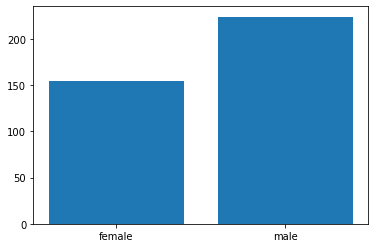

In [34]:
import collections
import matplotlib.pyplot as plt

plt.bar(df_sex.sex, df_sex.CONTEO)

In [35]:
255 + 171

426

##### Conteo por archivos = numero de participantes

In [36]:
import sqlite3
cnx = sqlite3.connect(':memory:')
def sql_query(query):
    return pd.read_sql(query, cnx)

df.to_sql('df', con=cnx, if_exists='append', index=False)

query= """ SELECT count(distinct file) as participant FROM df"""

In [37]:
df_participant=sql_query(query)
df_participant

,participant
0,379


#####  Edad de los participantes

In [38]:
df2=df.copy()
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df2['agerange'] = pd.cut(df.age, bins, labels = labels,include_lowest = True)

<AxesSubplot:>

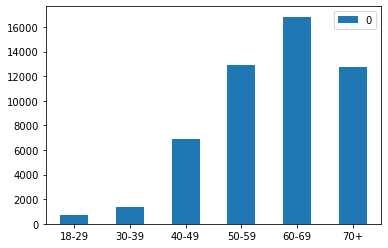

In [39]:
letter_counts = Counter(df2['agerange'])
df3= pd.DataFrame.from_dict(letter_counts, orient='index').reindex(labels)
df3.plot(kind='bar',rot=0)

<AxesSubplot:xlabel='agerange', ylabel='count'>

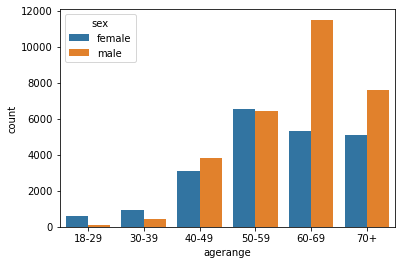

In [40]:
sns.countplot(x='agerange',hue='sex',data=df2)